## RNN 구현

#### RNN계층 구현

In [3]:
import numpy as np

In [2]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.cache

    dt = dh_next * (1 - h_enxt ** 2)
    db = np.sum(dt, axis = 0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

#### Time RNN 계층 구현

In [6]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful = False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful

  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype = 'f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype = 'f')

    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    dxs = np.empty((N, T, D), dtype = 'f')
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)    # 합산된 기울기
      dxs[:, t, :] = dx

      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    
    return dxs

## RNNLM 학습과 평가

#### RNNLM 구현

In [7]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2

/content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2


In [8]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')

    rnn_b = np.zeros('H').astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss

  def backward(self, dout = 1):
    dout = self.loss_layer.bavkward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()

#### RNNLM의 학습 코드

In [10]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100     # RNN의 은닉 상태 벡터의 원소 수
time_size = 5         # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]      # 입력
ts = corpus[1:]       # 출력(정답 레이블)
data_size = len(xs)
print(f'말뭉치 크기: {corpus_size}, 어휘 수: {vocab_size}')

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
  for iter in range(max_iters):
    # 미니배치 획득
    batch_x = np.empty((batch_size, time_size), dtype = 'i')
    batch_t = np.empty((batch_size, time_size), dtype = 'i')
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1
    
    # 기울기를 구하여 매개변수 갱신
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1

  # 에폭마다 퍼플렉서티 평가
  ppl = np.exp(total_loss / loss_count)
  print(f'| 에폭 {epoch +1} | 퍼플렉서티 {ppl:.2f}')
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 394.98
| 에폭 2 | 퍼플렉서티 265.39
| 에폭 3 | 퍼플렉서티 222.60
| 에폭 4 | 퍼플렉서티 212.77
| 에폭 5 | 퍼플렉서티 204.39
| 에폭 6 | 퍼플렉서티 201.13
| 에폭 7 | 퍼플렉서티 198.40
| 에폭 8 | 퍼플렉서티 194.86
| 에폭 9 | 퍼플렉서티 190.48
| 에폭 10 | 퍼플렉서티 190.78
| 에폭 11 | 퍼플렉서티 187.45
| 에폭 12 | 퍼플렉서티 189.62
| 에폭 13 | 퍼플렉서티 187.53
| 에폭 14 | 퍼플렉서티 188.71
| 에폭 15 | 퍼플렉서티 187.13
| 에폭 16 | 퍼플렉서티 185.84
| 에폭 17 | 퍼플렉서티 182.63
| 에폭 18 | 퍼플렉서티 178.32
| 에폭 19 | 퍼플렉서티 181.05
| 에폭 20 | 퍼플렉서티 182.89
| 에폭 21 | 퍼플렉서티 180.08
| 에폭 22 | 퍼플렉서티 178.51
| 에폭 23 | 퍼플렉서티 172.57
| 에폭 24 | 퍼플렉서티 176.84
| 에폭 25 | 퍼플렉서티 172.15
| 에폭 26 | 퍼플렉서티 173.34
| 에폭 27 | 퍼플렉서티 168.56
| 에폭 28 | 퍼플렉서티 163.91
| 에폭 29 | 퍼플렉서티 161.78
| 에폭 30 | 퍼플렉서티 159.87
| 에폭 31 | 퍼플렉서티 158.96
| 에폭 32 | 퍼플렉서티 154.28
| 에폭 33 | 퍼플렉서티 155.49
| 에폭 34 | 퍼플렉서티 150.95
| 에폭 35 | 퍼플렉서티 147.42
| 에폭 36 | 퍼플렉서티 143.52
| 에폭 37 | 퍼플렉서티 136.72
| 에폭 38 | 퍼플렉서티 135.39
| 에폭 39 | 퍼플렉서티 130.93
| 에폭 40 | 퍼플렉서티 126.33
| 에폭 41 | 퍼플렉서티 124.85
| 에폭 42 | 퍼플렉서티 118.90
| 에폭 43 | 퍼플렉서티 116

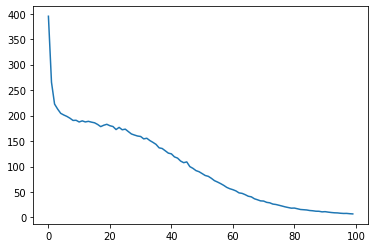

In [12]:
plt.plot(ppl_list)

#### RNNLM의 Trainer 클래스

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 418.02
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 394.27
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 278.07
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 224.89
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.56
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.88
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.65
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.95
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.94
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.74
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.72
| 에폭 12 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.46
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.79
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.16
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.19
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 191.22
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.04
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.35
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.30
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.71
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.96
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

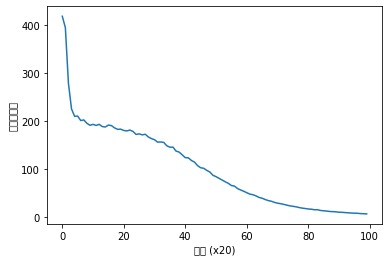

In [13]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

## 정리

- RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다.
- RNN의 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, 보통의 오차역전파법으로 학습할 수 있다.(=BPTT)
- 긴 시계열 데이터를 학습할 때는 데이터를 적당한 길이씩 모으고(이를 '블록'이라 한다.), 블록 단위로 BPTT에 의한 학습을 수행한다.(=Truncated BPTT)
- Truncated BPTT에서는 역전파의 연결만 끊는다.
- Truncated BPRR에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적'으로 입력해야 한다.
- 언어 모델은 단어 스퀀스를 확률로 해석한다.
- RNN 계층을 이용한 조건부 언어 모델은 (이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다.